In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from C4_theo_asymptotique__trapz import C4_court, C4_long
from DoubleRigidWallOverdampedBrownExp_Cython import RigidWallOverdampedLangevin3D
from Physic_function_problem import *
import cythonised_simu_part

from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import csv


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm


from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
    # 'axes.titlesize':10,
    # 'axes.labelsize':8,
}
# sns.set_context("notebook", rc={"lines.linewidth": 3})


sns.set_theme(context = "paper", style="ticks", rc=custom_params)

In [4]:
# Param fixé comme expériences
a = 1.519e-6 #1.12e-6/2
H = 40e-6
lD = 88.0e-9 #Répultion mur
kBT=1.38e-23*300
lB = 526e-9 #gravité
B = 5.0
eta=0.001

zz = np.linspace(-H+H*1e-3, H-H*1e-3, 1000)

dt = 1e-1
Nt = 10000000
Nt_sub = 1
tt = np.linspace(dt, dt*Nt, Nt)

In [5]:
simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, a=a, H=H, lD=lD, lB=lB, B=B, Nt_sub=Nt_sub)
simu.trajectory()

# Trajectory

In [6]:
Rs = np.zeros([Nt, 3])
Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

In [7]:
def plot_3D(ax, N: int = 20, N_c: int = 500):
    """
    Plot the trajectory in 3D, using N chunks of N_c points with a gradient of color indicating the time.
    """
    plt.ioff()
    plt.ion()
    
    cmap = plt.get_cmap("jet")

    for i in range(N - 1):
        ax.plot(
            simu.x[i * N_c : i * N_c + N_c],
            simu.y[i * N_c : i * N_c + N_c],
            simu.z[i * N_c : i * N_c + N_c],
            color=plt.cm.jet(1 * i / N), alpha = 0.9
        )
        
    ax = plt.gca()
    ax.ticklabel_format(style="sci")

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])



# PDF$(z)$ et $D(z)$ $\|$ et $\perp$

In [8]:
# PDF(z)
position = Rs[:, 2]
bins=100

hist_z, bin_edges = np.histogram(position[position < 30e-6], bins=bins, density=False)
binsPositions = (bin_edges[:-1] + bin_edges[1:]) / 2 
pdf = hist_z / np.trapz(hist_z, binsPositions*1e6)

z_Peq = np.linspace(-H, -32e-6, 1000)

In [ ]:
fig = plt.figure(figsize = (4, 4/1.2),  tight_layout=True)

ax1 = plt.subplot(221)
x    = simu.x*1e6
y    = simu.y*1e6
cols = tt

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='viridis')
lc.set_array(cols)
lc.set_linewidth(2)
line = ax1.add_collection(lc)
fig.colorbar(line,ax=ax1, location="right")
ax1.set(
    xlabel = r"$x$ ($\mu$m)",
    ylabel = r"$y$ ($\mu$m)",
)
ax1.set_xlim(min(x), max(x))
ax1.set_ylim(min(y), max(y))


ax2 = plt.subplot(222)
x    = simu.x*1e6
y    = simu.z*1e6
cols = tt
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis')
lc.set_array(cols)
lc.set_linewidth(2)
line = ax2.add_collection(lc)
fig.colorbar(line,ax=ax2, location="right")
ax2.set(
    xlabel = r"$x$ ($\mu$m)",
    ylabel = r"$z$ ($\mu$m)",
)
ax2.set_xlim(min(x), max(x))
ax2.set_ylim(min(y), max(y))


ax3 = plt.subplot(223)
ax3.plot(zz, D_para(zz, a, eta, H)/D_0(zz, a, eta), "-", label=r"$D_\|(z)$")
ax3.plot(zz, D_perp(zz, a, eta, H)/D_0(zz, a, eta), "-", color="tab:green", label=r"$D_\perp(z)$")
ax3.set(
    xlabel = r"$z$ (m)",
    ylabel = r"$D(z)/D_0$",
)


ax4 = plt.subplot(224)
ax4.semilogy(binsPositions*1e6, pdf, "o", color="tab:green", label=r"$\mathrm{Simulation}$")
ax4.plot(z_Peq*1e6, P_eq(z_Peq, B, lD, lB, H)/np.trapz(P_eq(z_Peq, B, lD, lB, H), z_Peq), "k-", label=r"$\mathrm{Theory}$",)
ax4.set(
    xlabel = r"$z$ ($\mu$m)",
    ylabel = r"$P_\mathrm{eq}(z)$ (m$^{-1}$)",
)

fig.tight_layout()
# plt.savefig("Figures/traj_Dz_PDFz_Version2.pdf")

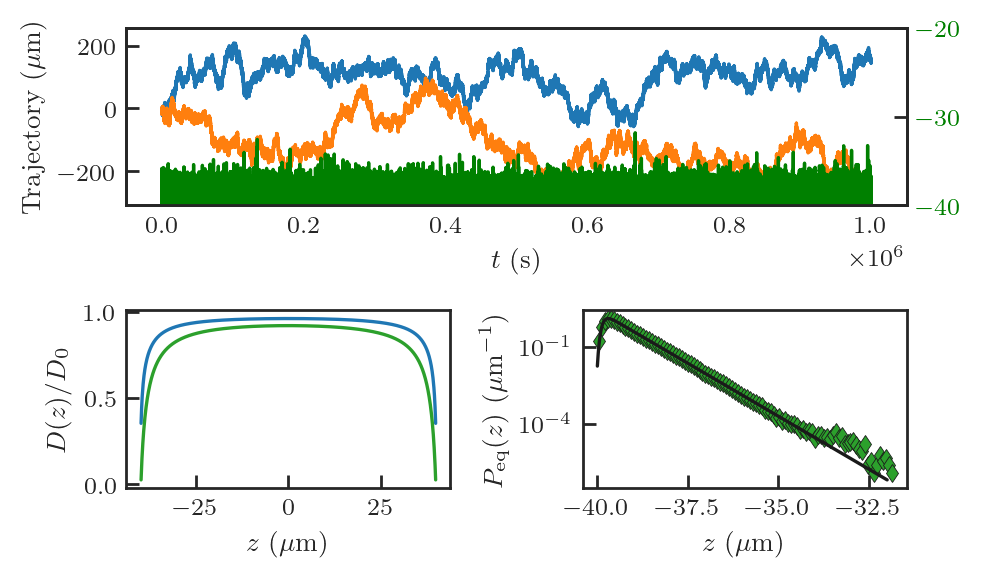

In [9]:
fig = plt.figure(figsize = (5, 5/1.68),  tight_layout=True)

ax1 = plt.subplot(211)
ax11=ax1.twinx()
ax11.plot(tt, simu.z*1e6, "-", color="green",)
ax11.set_ylabel("",color="green")
ax11.tick_params(axis='y', labelcolor="green")
ax11.set_ylim(-40, -20)
ax1.plot(tt, simu.x*1e6, color="tab:blue",)
ax1.plot(tt, simu.y*1e6,  color="tab:orange",)
ax1.set(
    xlabel = r"$t$ (s)",
    ylabel = r"Trajectory ($\mu$m)",
)

ax2 = plt.subplot(223)
ax2.plot(zz*1e6, D_para(zz, a, eta, H)/D_0(zz, a, eta), "-", color="tab:blue", label=r"$D_\|(z)$")
ax2.plot(zz*1e6, D_perp(zz, a, eta, H)/D_0(zz, a, eta), "-", color="tab:green", label=r"$D_\perp(z)$")
ax2.set(
    xlabel = r"$z$ ($\mu$m)",
    ylabel = r"$D(z)/D_0$",
)


ax3 = plt.subplot(224)
ax3.semilogy(binsPositions*1e6, pdf, "d", color="tab:green", label=r"$\mathrm{Simulation}$")
ax3.plot(z_Peq*1e6, P_eq(z_Peq, B, lD, lB, H)/np.trapz(P_eq(z_Peq, B, lD, lB, H), z_Peq*1e6), "k-", label=r"$\mathrm{Theory}$",)
ax3.set(
    xlabel = r"$z$ ($\mu$m)",
    ylabel = r"$P_\mathrm{eq}(z)$ ($\mu$m$^{-1}$)",
)
fig.tight_layout()

# plt.savefig("Figures/traj_Dz_PDFz.pdf")

# MSD et PDF($\Delta x$)

In [10]:
tau_x, msd_x = simu.MSD("x")

100%|███████████████████████████████████████████| 63/63 [00:01<00:00, 44.98it/s]


In [11]:
tau_z, msd_z = simu.MSD("z")

100%|███████████████████████████████████████████| 63/63 [00:01<00:00, 43.34it/s]


In [12]:
mean_Dx = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_para(zz, a, eta, H), zz)
mean_Dz = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_perp(zz, a, eta, H), zz)

In [13]:
N_tau = 1

tau_theo = np.linspace(1e-2, 5e6, 1000)
# PDF(dX)
dX = simu.x[N_tau:] - simu.x[:-N_tau]
std_num_dX = np.std(dX)
hist, bin_edges = np.histogram(dX, bins=50, density=False)
binsPositions_dX = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_dX = hist / np.trapz(hist, binsPositions_dX*1e6)


# PDF(dZ) court
dZ = simu.z[N_tau:] - simu.z[:-N_tau]
std_num_dZ = np.std(dZ)
hist, bin_edges = np.histogram(dZ, bins=50, density=False)
binsPositions_dZ = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_dZ = hist / np.trapz(hist, binsPositions_dZ*1e6)

# PDF(dZ) long
N_tau_long = 10000
dZ_long = simu.z[N_tau_long:] - simu.z[:-N_tau_long]
std_num_dZ_long = np.std(dZ_long)
hist, bin_edges = np.histogram(dZ_long, bins=50, density=False)
binsPositions_dZ_long = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_dZ_long = hist / np.trapz(hist, binsPositions_dZ_long*1e6)

dXX = np.linspace(-0.8, +0.8, 1000)
theory_x = P_Di_short_time(dXX*1e-6, dt*N_tau, D_para, a, eta, B, lD, lB, H)

dZZ = np.linspace(-0.8, +0.8, 1000)
theory_z = P_Di_short_time(dZZ*1e-6, dt*N_tau, D_perp, a, eta, B, lD, lB, H)

dZZ_long = np.linspace(-2*H, 2*H, 1000)
theory_z_long = Pdeltaz_long(dZZ_long, B, lD, lB, H)

plateau = np.trapz(dZZ_long**2 * theory_z_long, dZZ_long)

/home/e.millan/Documents/Stage2020-Nageurs-actifs-proche-de-parois-deformable/Cumulant4-cas-manips/Physic_function_problem.py:125: RuntimeWarning: overflow encountered in exp
  return np.exp(-B * np.exp(-H / lD) * (np.exp(-z / lD) + np.exp(z / lD)) - z / lB)


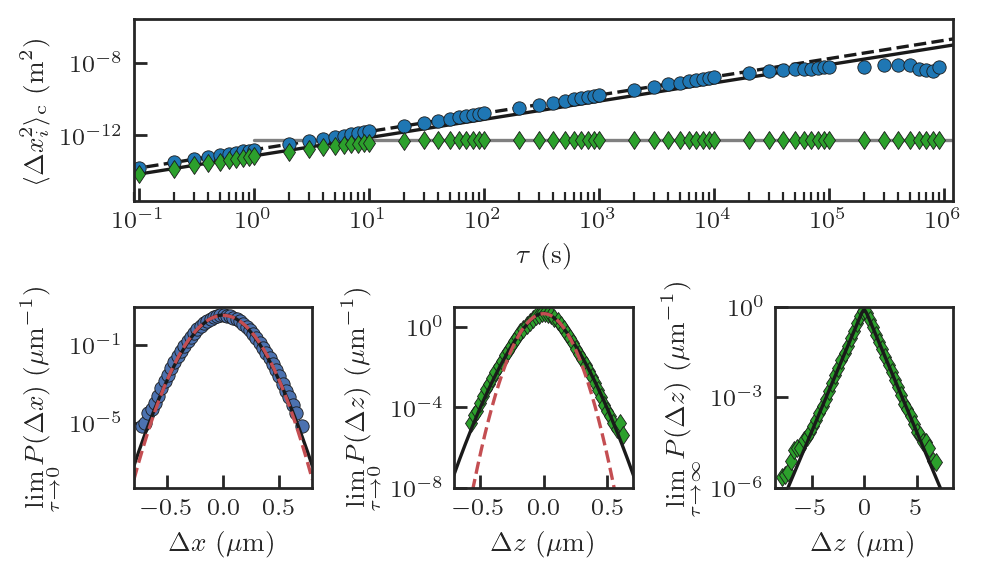

In [14]:
fig = plt.figure(figsize = (5, 5/1.68),  tight_layout=True)

ax1 = plt.subplot(211)
ax1.plot(tau_theo, 2*tau_theo*mean_Dx, "k--", label=r"$2 \langle D_{\|}(z) \rangle_0 \tau$")
ax1.plot(tau_theo, 2*tau_theo*mean_Dz, "k-", label=r"$2 \langle D_{\perp}(z) \rangle_0 \tau$")
ax1.plot(np.linspace(1, 5e6, 1000), plateau*np.ones(1000), "-",color="grey")
ax1.loglog(tau_x, msd_x, "o", color="tab:blue", label=r"$x_\|$")
ax1.loglog(tau_z, msd_z, "d", color="tab:green", label=r"$z$")
ax1.set_xlim(9e-2, 1.2e6)
ax1.set(
    xlabel = r"$\tau$ (s)",
    ylabel = r"$\langle \Delta x_i^2 \rangle_\mathrm{c}$ $(\mathrm{m}^2)$",
)

ax2 = plt.subplot(234)
ax2.semilogy(binsPositions_dX*1e6, pdf_dX/np.trapz(pdf_dX,binsPositions_dX*1e6), "o", label=r"Simulation $x$")
ax2.plot(dXX, theory_x/np.trapz(theory_x,dXX), "k-",label=r"Gaussian")
ax2.plot(dXX, gauss(dXX*1e-6, 0, np.sqrt(2*mean_Dx*dt*N_tau)) / np.trapz(gauss(dXX*1e-6, 0, np.sqrt(2*mean_Dx*dt*N_tau)), dXX), "r--",label=r"Gaussian")
ax2.set_xlim(-0.8, 0.8)
ax2.set(
    xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$\displaystyle{\lim_{\tau \to 0}} P(\Delta x)$  ($\mu$m$^{-1}$)",
)

ax3 = plt.subplot(235)
ax3.semilogy(binsPositions_dZ*1e6, pdf_dZ/np.trapz(pdf_dZ,binsPositions_dZ*1e6), "d", color="tab:green")
ax3.plot(dZZ, theory_z/np.trapz(theory_z,dZZ), "k-", label="Theory")
ax3.plot(dZZ, gauss(dZZ*1e-6, 0, np.sqrt(2*mean_Dz*dt*N_tau)) / np.trapz(gauss(dZZ*1e-6, 0, np.sqrt(2*mean_Dz*dt*N_tau)), dZZ), "r--",)
ax3.set_xlim(-0.7, 0.7)
ax3.set_ylim(1e-8, 10)
ax3.set(
    xlabel = r"$\Delta z$ ($\mu$m)",
    ylabel = r"$\displaystyle{\lim_{\tau \to 0}} P(\Delta z)$  ($\mu$m$^{-1}$)",
)

ax4 = plt.subplot(236)
ax4.semilogy(binsPositions_dZ_long*1e6, pdf_dZ_long/np.trapz(pdf_dZ_long,binsPositions_dZ_long*1e6), "d", color="tab:green")
ax4.plot(dZZ_long*1e6, theory_z_long/np.trapz(theory_z_long,dZZ_long*1e6), "k-")
ax4.set_xlim(-8.5, 8.5)
ax4.set_ylim(1e-6, 1)
ax4.set(
    xlabel = r"$\Delta z$ ($\mu$m)",
    ylabel = r"$\displaystyle{\lim_{\tau \to \infty}} P(\Delta z)$  ($\mu$m$^{-1}$)",
)
fig.tight_layout()
# plt.savefig("Figures/MSD_PDF-deplacement.pdf")

# Cumulant 4

In [15]:
data_simu = loadmat("C4_Datas/dataC4Ssimu_papier.mat", squeeze_me=True)


c4_simu = data_simu["C4"]
time_c4_simu = data_simu["t"]

In [16]:
Delta_z, pdf_Delta_z, dt = (np.array([-8.98109602e-07, -8.61452067e-07, -8.24794532e-07, -7.88136997e-07,
        -7.51479463e-07, -7.14821928e-07, -6.78164393e-07, -6.41506858e-07,
        -6.04849324e-07, -5.68191789e-07, -5.31534254e-07, -4.94876719e-07,
        -4.58219185e-07, -4.21561650e-07, -3.84904115e-07, -3.48246580e-07,
        -3.11589046e-07, -2.74931511e-07, -2.38273976e-07, -2.01616441e-07,
        -1.64958906e-07, -1.28301372e-07, -9.16438369e-08, -5.49863021e-08,
        -1.83287674e-08,  1.83287674e-08,  5.49863021e-08,  9.16438369e-08,
         1.28301372e-07,  1.64958906e-07,  2.01616441e-07,  2.38273976e-07,
         2.74931511e-07,  3.11589046e-07,  3.48246580e-07,  3.84904115e-07,
         4.21561650e-07,  4.58219185e-07,  4.94876719e-07,  5.31534254e-07,
         5.68191789e-07,  6.04849324e-07,  6.41506858e-07,  6.78164393e-07,
         7.14821928e-07,  7.51479463e-07,  7.88136997e-07,  8.24794532e-07,
         8.61452067e-07,  8.98109602e-07]),
 np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.06116451e-02,
        1.87809275e-01, 7.95368069e-01, 7.02693034e+00, 3.69756879e+01,
        1.73888649e+02, 7.16002227e+02, 2.72367024e+03, 9.33134863e+03,
        2.89119552e+04, 8.08095093e+04, 2.02981867e+05, 4.58170697e+05,
        9.24755102e+05, 1.65529884e+06, 2.61100278e+06, 3.58929210e+06,
        4.23285961e+06, 4.11947602e+06, 3.42162217e+06, 2.50025784e+06,
        1.62311721e+06, 9.42308267e+05, 4.91115577e+05, 2.30673461e+05,
        9.78413855e+04, 3.74643646e+04, 1.30004983e+04, 4.04407960e+03,
        1.15092438e+03, 2.93975584e+02, 6.82938531e+01, 1.19076134e+01,
        2.26971299e+00, 6.41246556e-01, 2.96452308e-02, 1.01063287e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]), 0.1)

Dt_z, C4_z = (np.array([0.01, 0.03, 0.04, 0.05, 1.0000e-01, 3.0000e-01, 4.0000e-01, 5.0000e-01, 1.0000e+00,
        1.3000e+00, 1.6000e+00, 2.6000e+00, 3.3000e+00, 5.4000e+00,
        8.6000e+00, 1.3800e+01, 2.2200e+01, 2.8100e+01, 3.5500e+01,
        5.6800e+01, 7.1900e+01, 9.1000e+01, 1.8420e+02, 2.3290e+02,
        2.9470e+02, 3.7270e+02, 4.7140e+02, 7.5430e+02, 1.5264e+03,
        2.4420e+03, 3.0888e+03, 6.2505e+03, 7.9060e+03, 1.0000e+04]),
 [1.8148283109529796e-29,
  1.5747673427044405e-28,
  2.777760058341669e-28,
  4.305402065223981e-28,
  1.656793501575856e-27,
  2.7606094541986627e-27,
  4.125176685084375e-27,
  1.0441464626649322e-26,
  1.6365006260383524e-26,
  4.077223994388704e-26,
  9.149940938781592e-26,
  1.8554459080602042e-25,
  3.1035830966278854e-25,
  3.6691299994573685e-25,
  4.098065458594404e-25,
  4.5318307593088375e-25,
  4.527208567526357e-25,
  4.35753689185392e-25,
  1.2145415159720604e-25,
  -2.381143410510063e-25,
  -8.60211409018589e-25,
  -1.9600045179521526e-24,
  -3.906079580666042e-24,
  -1.2316436837178852e-23,
  -5.258745097985626e-23,
  -1.3460288013572492e-22,
  -2.153488766898982e-22,
  -8.818456003948998e-22,
  -1.4108363916760963e-21,
  np.nan])

In [22]:
D4_long_theo = 1.2691e-27 #1.5074e-27
C4_long_theo = 1.0350e-26 #1.4039e-26
A4_theo_x = C4_court(D=D_para, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta, dx=1e-8)
A4_theo_z = C4_court(D=D_perp, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta, dx=1e-8)

t_short = np.linspace(1e-4, 50, 1000)
t_long = np.linspace(13, 1e5, 1000)

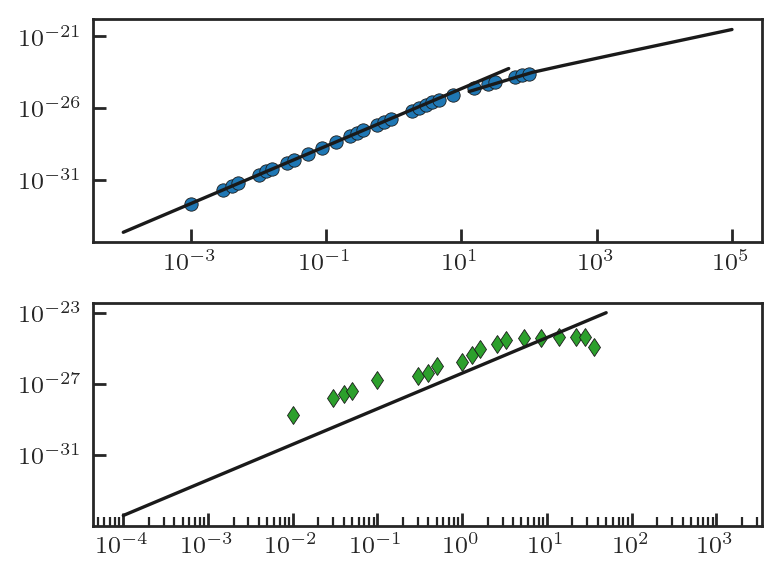

In [23]:
fig = plt.figure(figsize = (4, 5/1.68),  tight_layout=True)

ax1 = plt.subplot(211)
ax1.loglog(time_c4_simu, c4_simu, "o", color="tab:blue")
ax1.plot(t_short, A4_theo_x*t_short**2, "k-" )
ax1.plot(t_long, 24*D4_long_theo*t_long-24*C4_long_theo, "k-" )

ax2 = plt.subplot(212)
ax2.loglog(Dt_z[:-4], C4_z, "d", color="tab:green")
ax2.plot(t_short, A4_theo_z*t_short**2, "k-" )


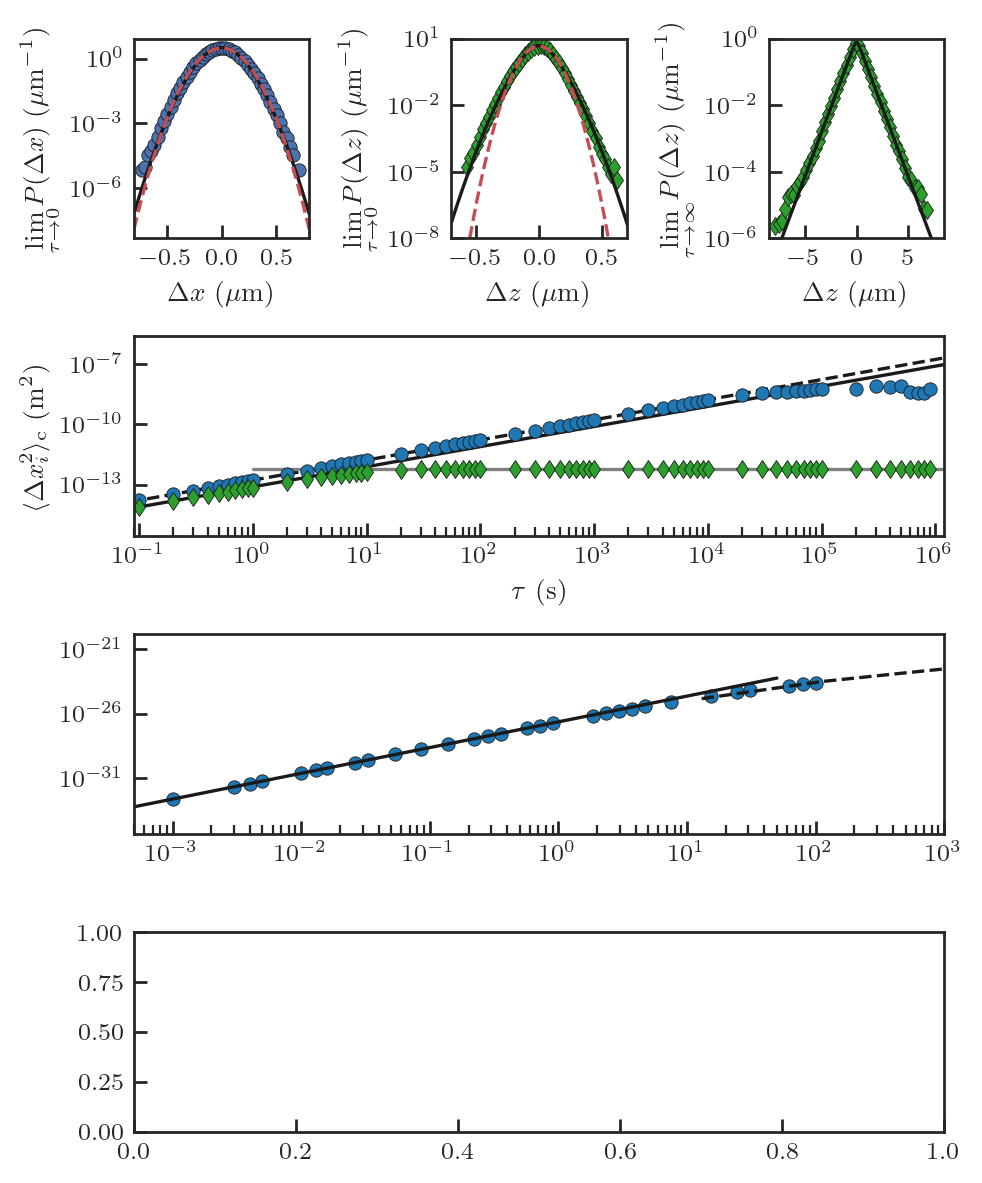

In [27]:
fig = plt.figure(figsize = (5, 5*2/1.68),  tight_layout=True)

ax1 = plt.subplot(431)
ax1.semilogy(binsPositions_dX*1e6, pdf_dX/np.trapz(pdf_dX,binsPositions_dX*1e6), "o", label=r"Simulation $x$")
ax1.plot(dXX, theory_x/np.trapz(theory_x,dXX), "k-",label=r"Gaussian")
ax1.plot(dXX, gauss(dXX*1e-6, 0, np.sqrt(2*mean_Dx*dt*N_tau)) / np.trapz(gauss(dXX*1e-6, 0, np.sqrt(2*mean_Dx*dt*N_tau)), dXX), "r--",label=r"Gaussian")
ax1.set_xlim(-0.8, 0.8)
ax1.set(
    xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$\displaystyle{\lim_{\tau \to 0}} P(\Delta x)$  ($\mu$m$^{-1}$)",
)


ax2 = plt.subplot(432)
ax2.semilogy(binsPositions_dZ*1e6, pdf_dZ/np.trapz(pdf_dZ,binsPositions_dZ*1e6), "d", color="tab:green")
ax2.plot(dZZ, theory_z/np.trapz(theory_z,dZZ), "k-", label="Theory")
ax2.plot(dZZ, gauss(dZZ*1e-6, 0, np.sqrt(2*mean_Dz*dt*N_tau)) / np.trapz(gauss(dZZ*1e-6, 0, np.sqrt(2*mean_Dz*dt*N_tau)), dZZ), "r--",)
ax2.set_xlim(-0.7, 0.7)
ax2.set_ylim(1e-8, 10)
ax2.set(
    xlabel = r"$\Delta z$ ($\mu$m)",
    ylabel = r"$\displaystyle{\lim_{\tau \to 0}} P(\Delta z)$  ($\mu$m$^{-1}$)",
)


ax3 = plt.subplot(433)
ax3.semilogy(binsPositions_dZ_long*1e6, pdf_dZ_long/np.trapz(pdf_dZ_long,binsPositions_dZ_long*1e6), "d", color="tab:green")
ax3.plot(dZZ_long*1e6, theory_z_long/np.trapz(theory_z_long,dZZ_long*1e6), "k-")
ax3.set_xlim(-8.5, 8.5)
ax3.set_ylim(1e-6, 1)
ax3.set(
    xlabel = r"$\Delta z$ ($\mu$m)",
    ylabel = r"$\displaystyle{\lim_{\tau \to \infty}} P(\Delta z)$  ($\mu$m$^{-1}$)",
)

ax4 = plt.subplot(412)
ax4.plot(tau_theo, 2*tau_theo*mean_Dx, "k--", label=r"$2 \langle D_{\|}(z) \rangle_0 \tau$")
ax4.plot(tau_theo, 2*tau_theo*mean_Dz, "k-", label=r"$2 \langle D_{\perp}(z) \rangle_0 \tau$")
ax4.plot(np.linspace(1, 5e6, 1000), plateau*np.ones(1000), "-",color="grey")
ax4.loglog(tau_x, msd_x, "o", color="tab:blue", label=r"$x_\|$")
ax4.loglog(tau_z, msd_z, "d", color="tab:green", label=r"$z$")
ax4.set_xlim(9e-2, 1.2e6)
ax4.set(
    xlabel = r"$\tau$ (s)",
    ylabel = r"$\langle \Delta x_i^2 \rangle_\mathrm{c}$ $(\mathrm{m}^2)$",
)

ax5 = plt.subplot(413)
ax5.loglog(time_c4_simu, c4_simu, "o", color="tab:blue")
ax5.plot(t_short, A4_theo_x*t_short**2, "k-" )
ax5.plot(t_long, 24*D4_long_theo*t_long-24*C4_long_theo, "k--" )
ax5.set_xlim(5e-4, 1e3)

ax6 = plt.subplot(414)

# Convergence

In [34]:
import glob


In [28]:
Datas_parquet = "C4_Datas/parquet_7_50_sigma__lD_8p800000e-08_lB_5p260000e-07_B_5p000000e+00_H_4p000000e-05_a_1p519000e-06_dt_1p000000e-03_Nt_1000000_Ntsub_1_/"




In [50]:
pd.read_parquet(Datas_parquet+'/1', engine='pyarrow')
files=glob.glob(Datas_parquet+"/*")


Ntime = []
for i in files:
    Ntime.append(int(i.split("/")[-1]))

I=np.argsort(Ntime)
files = [files[i] for i in I]

Ntime = np.sort(Ntime)

datas = {}
for i in files:
    name = i.split("/")[-1]
    datas[name] = pd.read_parquet(i)
    

In [51]:
datas["1"]

,-8.821819989358591e-08,-8.461745704078648e-08,-8.101671418798706e-08,-7.741597133518762e-08,-7.381522848238821e-08,-7.021448562958879e-08,-6.661374277678936e-08,-6.301299992398995e-08,-5.9412257071190514e-08,-5.581151421839109e-08,...,5.581151421839108e-08,5.941225707119051e-08,6.301299992398992e-08,6.661374277678935e-08,7.021448562958877e-08,7.38152284823882e-08,7.741597133518762e-08,8.101671418798705e-08,8.461745704078648e-08,8.82181998935859e-08
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,22.0,...,22.0,9.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,18.0,...,18.0,7.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,29.0,...,25.0,9.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,10.0,22.0,...,21.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,24.0,...,23.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,1.0,10.0,58.0,164.0,616.0,1957.0,6707.0,20810.0,63127.0,182406.0,...,182495.0,63270.0,20680.0,6621.0,1986.0,544.0,174.0,52.0,16.0,7.0
11,1.0,10.0,57.0,165.0,616.0,1952.0,6710.0,20809.0,63126.0,182594.0,...,182520.0,63227.0,20737.0,6624.0,2001.0,540.0,174.0,53.0,16.0,7.0
12,1.0,10.0,57.0,162.0,618.0,1956.0,6715.0,20818.0,63119.0,182471.0,...,182462.0,63232.0,20718.0,6636.0,1992.0,536.0,176.0,53.0,16.0,7.0


In [52]:
Ntime

array([     1,      2,      3,      4,      5,      6,      8,     10,
           13,     16,     21,     26,     33,     42,     54,     68,
           86,    109,    138,    175,    222,    281,    355,    449,
          568,    719,    910,   1151,   1456,   1842,   2329,   2947,
         3727,   4714,   5963,   7543,   9540,  12067,  15264,  19306,
        24420,  30888,  39069,  49417,  62505,  79060, 100000])

In [57]:
datas["1"].head()

,-8.821819989358591e-08,-8.461745704078648e-08,-8.101671418798706e-08,-7.741597133518762e-08,-7.381522848238821e-08,-7.021448562958879e-08,-6.661374277678936e-08,-6.301299992398995e-08,-5.9412257071190514e-08,-5.581151421839109e-08,...,5.581151421839108e-08,5.941225707119051e-08,6.301299992398992e-08,6.661374277678935e-08,7.021448562958877e-08,7.38152284823882e-08,7.741597133518762e-08,8.101671418798705e-08,8.461745704078648e-08,8.82181998935859e-08
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,22.0,...,22.0,9.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,18.0,...,18.0,7.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,29.0,...,25.0,9.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,10.0,22.0,...,21.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,24.0,...,23.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
